In [30]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mtplt
import numpy as np
import gtsam
import image_mosiacing as im
import optimizer as gt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Why use SIFT over ORB?
SIFT is better than ORB for stitching the Skerki dataset because it is more robust to scale, rotation, and illumination changes, which are common challenges in underwater imagery. The low contrast and variable lighting in the Skerki dataset make SIFT's gradient-based feature descriptors particularly useful for detecting and matching keypoints reliably, even in textureless or poorly lit regions. While ORB is faster, it is less effective in handling significant lighting variations and scale differences, which are critical in this challenging dataset.

## Tuning SIFT

Since the images are low contrast, default SIFT parameters find it difficult to detect features. This is mitigated by increasing the Octave layers to 5, `contrastThreshold` = 0.03 (lowered from 0.04 to make the contrast requirement less strict to qualify as a feature), and `sigma` = 1.0 (reduce the blurring on the zeroth octave)

## Normalization
Before computing homography between two images, the good matches coordinates are normalized between -1 and 1 centered around 0. This makes the matrices involved in the homography computation well conditioned. Bad conditioning happens when the coordinates near images edges have huge coordinates compared to others. Following is the normalization matrix N:

\begin{bmatrix}
\frac{2}{\text{height}} & 0 & -1 \\
0 & \frac{2}{\text{width}} & -1 \\
0 & 0 & 1
\end{bmatrix}

Thus the effective homography is N-1 * H * N
Where is the homography between two images corresponding to two scaled down images.

## Planar Homography Assumption and Getting Rotation and Translation
The **planar homography assumption** states that the motion between two images can be modeled as a transformation on a 2D plane, assuming all points lie on a flat surface. This simplifies the motion to **in-plane translation** (movement in \(x\) and \(y\)) and **rotation** (yaw or \( \theta \)).

In such planar motion, **translation** and **rotation** are generally **decoupled**, meaning the error in translation does not strongly affect the rotation and vice versa. Therefore, it's reasonable to assume **independent noise** for \(x\), \(y\), and \( \theta \), leading to a diagonal covariance matrix for the uncertainty in these variables.

By using **reprojection error** from the homography, we estimate the uncertainty (covariance) in translation and rotation. A small reprojection error indicates high confidence (small covariances), while a large error suggests more uncertainty (larger covariances), resulting in a simple and effective method for calculating the covariance matrix.


## Load and display 6 images

In [31]:
min_inliers = 20
max_reprojection_error = 2.0
image_directories = ["six_images"]
image_mosiacking = im.ImageMosiacking(image_directories, mosaic_name="six_images_stitched", min_inliers=min_inliers,
                                      max_reprojection_error=max_reprojection_error)

image_mosiacking.get_images_for_mosaicking()

## Stitch Images in Temporal Sequence

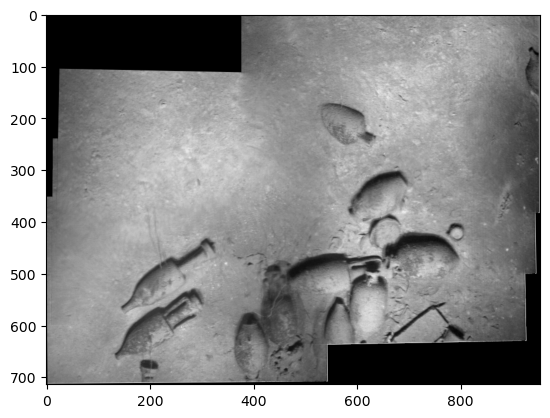

Formulating initial trajectory...
Image no:  1
H [[ 9.91015311e-01  1.57149404e-02 -7.05269297e+00]
 [-1.57149404e-02  9.91015311e-01  1.29535670e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_2D [ -7.05269297 129.53566986]
YAW in degrees -0.9086581867635234
Image no:  2
H [[ 1.00376421e+00  3.75221791e-03 -2.49842580e+01]
 [-3.75221791e-03  1.00376421e+00  1.31201928e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_2D [-24.98425802 131.20192813]
YAW in degrees -0.21421944463435877
Image no:  3
H [[ 9.44619427e-01 -1.12160182e-02 -3.51049895e+02]
 [ 1.12160182e-02  9.44619427e-01  8.60886684e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_2D [-351.04989477   86.08866843]
YAW in degrees 0.6804026429470282
Image no:  4
H [[ 9.99459489e-01 -1.38183148e-02  1.47915011e+01]
 [ 1.38183148e-02  9.99459489e-01 -1.19372078e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_2D [  14.7915011  -119.37207794]
YAW in degrees 0.7922582752555133
Image no:  5
H 

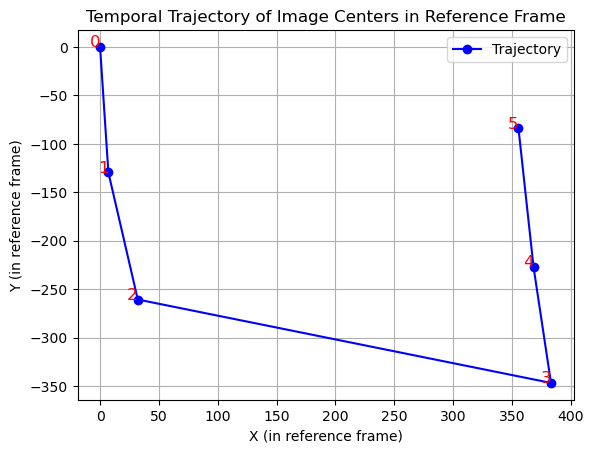

In [32]:
image_mosiacking.align_images_in_temporal_sequence()
image_mosiacking.get_temporal_trajectory()

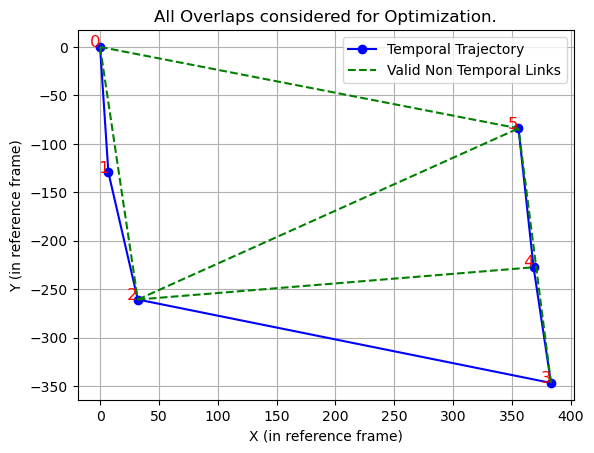

In [33]:
image_mosiacking.propose_non_temporal_links()
image_mosiacking.validate_proposed_links()

image_mosiacking.plot_all_links()

## Optimization using GTSAM


INITIAL ESTIMATES
Values with 6 values:
Value 0: (gtsam::Pose2)
(0, 0, 0)

Value 1: (gtsam::Pose2)
(7.05269297, -129.53567, 0.0158560854)

Value 2: (gtsam::Pose2)
(32.036951, -260.737598, 0.0195942147)

Value 3: (gtsam::Pose2)
(383.086846, -346.826266, 0.00772118855)

Value 4: (gtsam::Pose2)
(368.295345, -227.454188, -0.00610371835)

Value 5: (gtsam::Pose2)
(355.461572, -84.0734422, -0.0198687899)


GRAPH
NonlinearFactorGraph: size: 11

Factor 0: PriorFactor on 0
  prior mean:  (0, 0, 0)
isotropic dim=3 sigma=0.1

Factor 1: BetweenFactor(1,0)
  measured:  (-7.05269297, 129.53567, -0.0158560854)
  noise model: diagonal sigmas [2.07457058; 2.07457058; 0.0362080872];

Factor 2: BetweenFactor(2,1)
  measured:  (-24.984258, 131.201928, -0.00373812931)
  noise model: diagonal sigmas [1.67076031; 1.67076031; 0.0291602684];

Factor 3: BetweenFactor(3,2)
  measured:  (-351.049895, 86.0886684, 0.0118730261)
  noise model: diagonal sigmas [1.06882085; 1.06882085; 0.0186544429];

Factor 4: Betwee

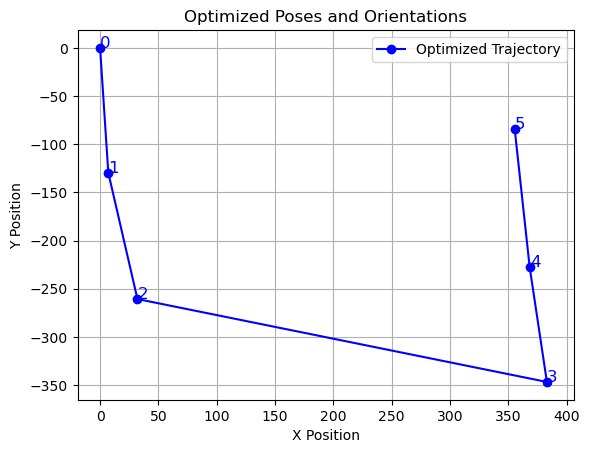

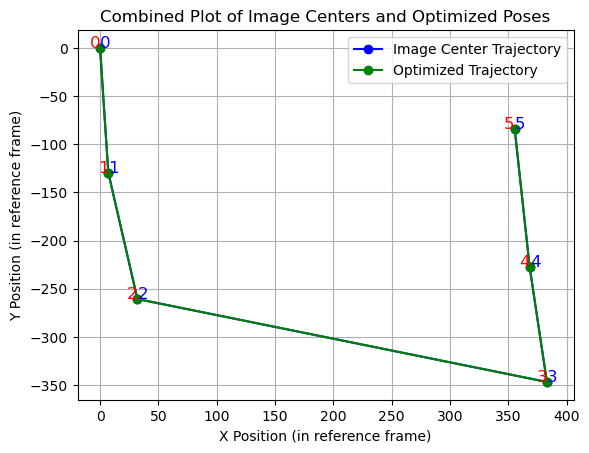

Marginals: Graph:  
size: 11
factor 0: 
  A[0] = [
	10, 0, 0;
	0, 10, 0;
	0, 0, 10
]
  b = [ 0 0 0 ]
  No noise model
factor 1: 
  A[1] = [
	-0.481966873, 0.00764274839, 62.4397507;
	-0.00764274839, -0.481966873, 3.39959172;
	-0, -0, -27.6181394
]
  A[0] = [
	0.482027466, 0, 0;
	0, 0.482027466, 0;
	0, 0, 27.6181394
]
  b = [ -0.989581 -0.061751        -0 ]
  No noise model
factor 2: 
  A[2] = [
	-0.598525719, 0.00223737695, 78.7555048;
	-0.00223737695, -0.598525719, 13.7068468;
	-0, -0, -34.2932372
]
  A[1] = [
	0.598529901, 0, 0;
	0, 0.598529901, 0;
	0, 0, 34.2932372
]
  b = [    -1.54042   -0.283676 1.48723e-17 ]
  No noise model
factor 3: 
  A[3] = [
	-0.935544548, -0.0111082668, 86.9652289;
	0.0111082668, -0.935544548, 326.804792;
	-0, -0, -53.6065325
]
  A[2] = [
	0.935610493, 0, 0;
	0, 0.935610493, 0;
	0, 0, 53.6065325
]
  b = [ -0.661727  -2.52589        -0 ]
  No noise model
factor 4: 
  A[4] = [
	-0.456816036, -0.00631584155, -54.5868419;
	0.00631584155, -0.456816036, -6.33635

In [37]:
optimizer = gt.GTSAMOptimizer(image_mosiacking_obj=image_mosiacking)
optimizer.build_graph()
print("\nINITIAL ESTIMATES")
print(optimizer.initial_estimate)
print("GRAPH")
print(optimizer.graph)
optimizer.optimize_graph()

print("\nRESULT")
print(optimizer.result)
optimizer.plot_optimized_trajectory()
optimizer.plot_combined_trajectory_and_poses()

marginals = gtsam.Marginals(optimizer.graph, optimizer.result)
print(marginals)


## Load 29 Images

In [41]:
image_directories = ["29images/first_column", "29images/second_column", "29images/third_column", "29images/fourth_column"]
image_mosiacking_29 = im.ImageMosiacking(image_directories, False, "all_images", min_inliers=20, max_reprojection_error=2.0)

image_mosiacking_29.get_images_for_mosaicking()

## Detect & Match Features, Align Images in a temporal sequence

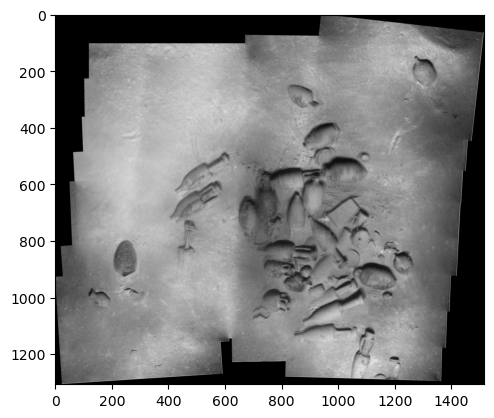

Formulating initial trajectory...
Image no:  1
H [[ 9.98661674e-01  1.27603629e-02 -1.66013603e+01]
 [-1.27603629e-02  9.98661674e-01  1.24416184e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_2D [-16.60136029 124.4161841 ]
YAW in degrees -0.7321930079123694
Image no:  2
H [[ 9.86205771e-01  2.66042236e-02 -1.04751054e+01]
 [-2.66042236e-02  9.86205771e-01  1.35174758e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_2D [-10.47510537 135.17475813]
YAW in degrees -1.545547309727525
Image no:  3
H [[ 9.95690655e-01  1.23786026e-02 -3.60324254e+01]
 [-1.23786026e-02  9.95690655e-01  1.25199093e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_2D [-36.03242538 125.19909338]
YAW in degrees -0.7124089785448616
Image no:  4
H [[ 1.00518204e+00 -1.06191415e-02 -1.85213229e+01]
 [ 1.06191415e-02  1.00518204e+00  1.04900770e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_2D [-18.5213229  104.90076983]
YAW in degrees 0.6053870112077734
Image no:  5
H [[ 1.

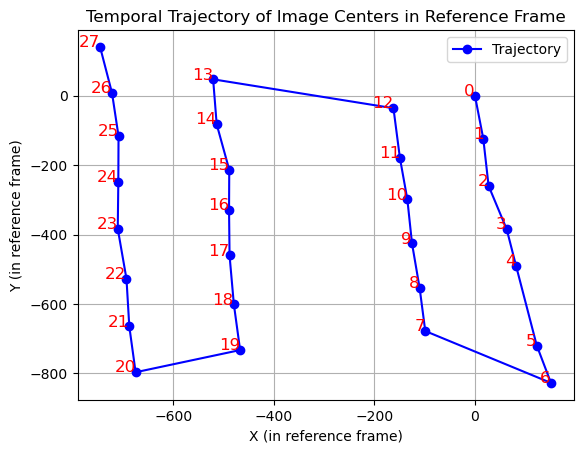

In [42]:
image_mosiacking_29.align_images_in_temporal_sequence()
image_mosiacking_29.get_temporal_trajectory()

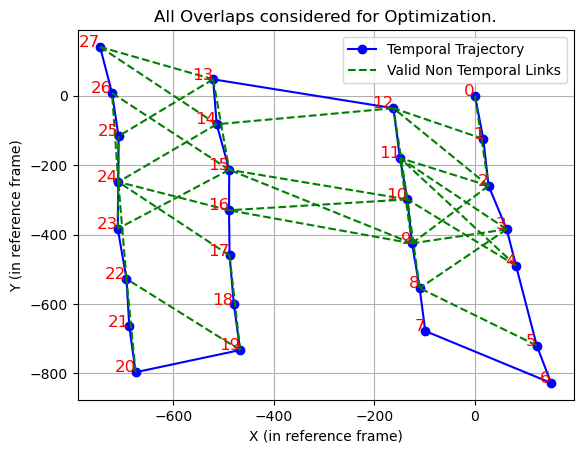

In [43]:
image_mosiacking_29.propose_non_temporal_links()
image_mosiacking_29.validate_proposed_links()
image_mosiacking_29.plot_all_links()

## Optimization using GTSAM

NonlinearFactorGraph: size: 62

Factor 0: PriorFactor on 0
  prior mean:  (0, 0, 0)
isotropic dim=3 sigma=0.1

Factor 1: BetweenFactor(1,0)
  measured:  (-16.6013603, 124.416184, -0.012776768)
  noise model: diagonal sigmas [1.5956899; 1.5956899; 0.0278500425];

Factor 2: BetweenFactor(2,1)
  measured:  (-10.4751054, 135.174758, -0.0269698006)
  noise model: diagonal sigmas [2.61154776; 2.61154776; 0.045580107];

Factor 3: BetweenFactor(3,2)
  measured:  (-36.0324254, 125.199093, -0.0124315367)
  noise model: diagonal sigmas [2.33902666; 2.33902666; 0.0408237165];

Factor 4: BetweenFactor(4,3)
  measured:  (-18.5213229, 104.90077, 0.0105640033)
  noise model: diagonal sigmas [2.18817575; 2.18817575; 0.0381908715];

Factor 5: BetweenFactor(5,4)
  measured:  (-41.229422, 229.990777, -0.032680337)
  noise model: diagonal sigmas [1.91839843; 1.91839843; 0.0334823689];

Factor 6: BetweenFactor(6,5)
  measured:  (-28.2598691, 107.766031, 0.00974151307)
  noise model: diagonal sigmas [1.90112

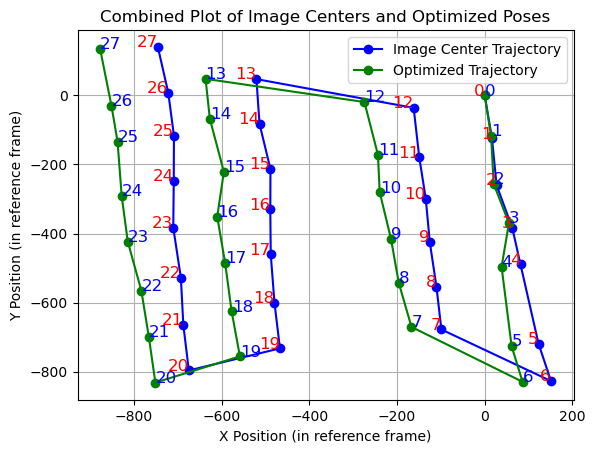

In [44]:
optimizer_2 = gt.GTSAMOptimizer(image_mosiacking_obj=image_mosiacking_29)
optimizer_2.build_graph()
print(optimizer_2.graph)
print(optimizer_2.initial_estimate)
optimizer_2.optimize_graph()
print(optimizer_2.result)
optimizer_2.plot_combined_trajectory_and_poses()